# **Downloading Dataset**

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"

Mounted at /content/drive


In [ ]:
! kaggle datasets download praveengovi/emotions-dataset-for-nlp

Dataset URL: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp
License(s): CC-BY-SA-4.0
  0% 0.00/721k [00:00<?, ?B/s]
100% 721k/721k [00:00<00:00, 686MB/s]


In [ ]:
! unzip /content/emotions-dataset-for-nlp.zip

Archive:  /content/emotions-dataset-for-nlp.zip
  inflating: test.txt                
  inflating: train.txt               
  inflating: val.txt                 


# 🧠 Emotion Detection from Text using Machine Learning

### 📌 Project Overview

This project focuses on building a robust, multi-method system for **emotion classification** using textual data. Emotions are a vital part of human communication, and the ability to detect them computationally has wide applications — from mental health monitoring to personalized customer support and sentiment-aware chatbots.

Using a labeled dataset of short text samples annotated with emotional categories (such as *joy*, *anger*, *sadness*, *fear*, and others), we apply a range of Natural Language Processing (NLP) techniques to extract meaningful features and train several machine learning models. Our pipeline is designed to evaluate how well each method performs under different feature representations.

---

### 🎯 Objectives

- Preprocess and clean raw textual data
- Experiment with diverse text representations (TF-IDF, Bag-of-Words, Word2Vec, POS tags, Dependency Parsing)
- Train multiple classifiers, including:
  - Multilayer Perceptron (MLP)
  - Decision Tree
  - Logistic Regression
- Compare models and features to determine the most effective combinations
- Build a flexible prediction pipeline for real-world emotion inference

---

### 🛠️ Key Techniques

- **Text Vectorization:** TF-IDF, CountVectorizer, Word2Vec
- **Linguistic Analysis:** POS tagging, Dependency Parsing
- **Machine Learning Models:** MLP, Decision Tree, Logistic Regression
- **Evaluation:** Accuracy, performance tables, and interpretability

---

### 📈 Outcome

This notebook presents a detailed exploration of how different representations of language affect model performance in emotion recognition. Through careful experimentation and structured analysis, we identify optimal feature-model pairings and provide insights into how emotional signals are embedded in language.

The final system is modular, interpretable, and suitable for both academic and applied NLP tasks — ready to be extended into production environments or deeper research directions.


# 🔽 **Data Acquisition**

To build an effective emotion classification system, we begin by obtaining a labeled dataset containing a variety of textual inputs. Each sample in the dataset is tagged with an associated emotion such as *joy*, *anger*, *sadness*, or *surprise*. This labeled data is crucial, as it defines the learning scope and performance ceiling of our model. During this step, we also ensure the dataset is clean, complete, and formatted properly for processing.

---

### 🏗️ **Dataset Construction**

After importing the data, we convert it into a structured format using a DataFrame. This makes it easier to inspect and manipulate. At this stage, we:
- Remove missing or duplicated entries to maintain data quality  
- Review label distribution to check for imbalances across emotions  
- Randomly shuffle records to prevent ordering bias  

Laying this foundation ensures consistent and unbiased input for the learning pipeline.



In [ ]:
import re
import pandas as pd
import numpy as np
import random
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import joblib

In [ ]:
# Open and read the file
with open('train.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

# Separate into features and labels
features = []
labels = []

for line in lines:
    if ';' in line:
        text, emotion = line.strip().split(';')
        features.append(text)
        labels.append(emotion)

# Create a DataFrame
df = pd.DataFrame({
    'text': features,
    'label': labels
})

In [ ]:
df

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [ ]:
def fix_split_contractions(text):
    # Define a pattern to fix common contractions split by spaces
    contractions_dict = {
        r'\b(ve)\b' : "have",
        r'\b(ive)\b': "I've",
        r'\b(im)\b': "I'm",
        r'\b(ill)\b': "I'll",
        r'\b(it)\b': "it",
        r'\b(can t)\b': "can't",
        r'\b(wont)\b': "won't",
        r'\b(dont)\b': "don't",
        r'\b(isn t)\b': "isn't",
        r'\b(arent)\b': "aren't",
        r'\b(have)\b': "have",
        r'\b(willnot)\b': "won't",
        r'\b(wouldve)\b': "would've",
        r'\b(shouldve)\b': "should've",
        r'\b(mightve)\b': "might've",
        r'\b(mustve)\b': "must've",
        r'\b(didnt)\b': "didn't"
    }

    # Loop through the contractions dictionary and replace them
    for pattern, replacement in contractions_dict.items():
        text = re.sub(pattern, replacement, text)

    return text

In [ ]:
df['text'] = df['text'].apply(fix_split_contractions)

In [ ]:
df

,text,label
0,i didn't feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,I'm grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and I...,anger


In [ ]:
# Initialize the CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=1000)

# Fit and transform the text data
X = vectorizer.fit_transform(df['text'])

# Get the sum of word frequencies
word_freq = X.toarray().sum(axis=0)

# Create a DataFrame of words and their frequencies
word_freq_df = pd.DataFrame(list(zip(vectorizer.get_feature_names_out(), word_freq)), columns=['Word', 'Frequency'])

# Sort the words by frequency
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

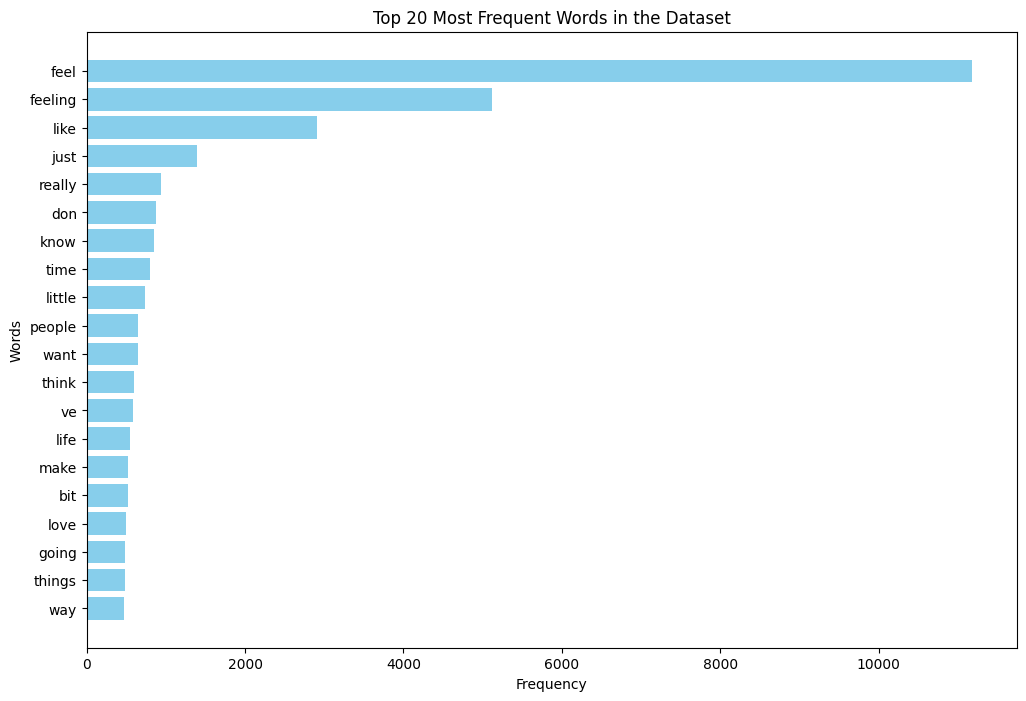

In [ ]:
# Plot the top 20 most frequent words
plt.figure(figsize=(12, 8))
plt.barh(word_freq_df.head(20)['Word'], word_freq_df.head(20)['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Most Frequent Words in the Dataset')
plt.gca().invert_yaxis()  # Invert y-axis to have the most frequent word on top
plt.show()

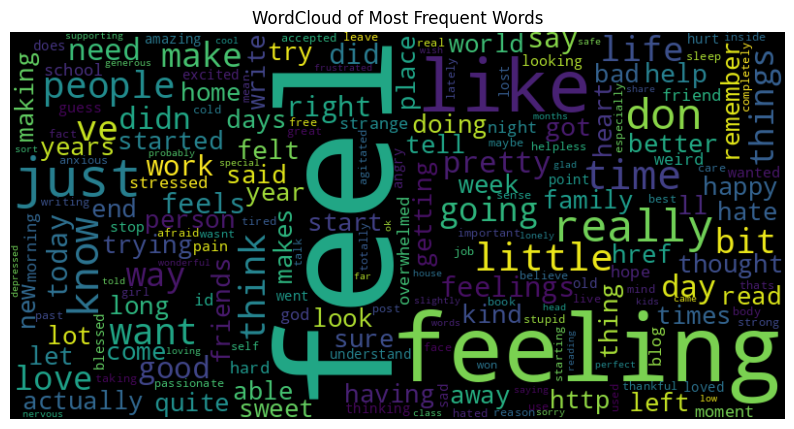

In [ ]:
# Optionally, create a WordCloud for visualization
wordcloud = WordCloud(stopwords='english', width=800, height=400, max_words=200).generate_from_frequencies(dict(zip(word_freq_df['Word'], word_freq_df['Frequency'])))

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Most Frequent Words')
plt.show()

# 🧼 **Lemmatization**

Lemmatization reduces each word in the dataset to its canonical dictionary form, preserving its grammatical structure and meaning. This step enhances model understanding and generalization. For example:
- “running” becomes “run”  
- “mice” becomes “mouse”  

Unlike stemming, lemmatization avoids producing awkward or incomplete root forms. It's especially important in emotion analysis, where small changes in wording can shift the emotional tone.


In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Function for lemmatization and stopword removal
def lemmatize_and_remove_stopwords(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

In [ ]:
df['text'] = df['text'].apply(lemmatize_and_remove_stopwords)

# 🧱 **Tokenization**

Text must be broken down into manageable parts for computational models to understand — this is achieved through tokenization. Each sentence is split into smaller units called tokens (usually words). Alongside this, we perform:
- Lowercasing to standardize inputs  
- Punctuation removal to focus on semantic content  
- Optional stopword removal to reduce noise  

Tokenization forms the bridge between natural language and numerical processing.


In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Tokenize the text into words
tokens = df['text'].apply(word_tokenize)

# 📊 **TF-IDF Vectorization**

To enable machine learning models to process text, we transform each sentence into a numerical representation using **TF-IDF** (Term Frequency-Inverse Document Frequency). This technique assigns weights to words based on how informative they are:
- Common words across the dataset are down-weighted  
- Emotion-specific or unique terms are emphasized  

The result is a sparse matrix of features that captures the essence of each text entry — ideal for algorithms like Logistic Regression or SVM.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tf_idf_vectorizer = TfidfVectorizer()
tf_idf_features = tf_idf_vectorizer.fit_transform(df['text'])

In [ ]:
tf_idf = joblib.dump(tf_idf_vectorizer, 'TF_IDF.joblib')

In [ ]:
df_tf_idf = pd.DataFrame(tf_idf_features.toarray(), columns=tf_idf_vectorizer.get_feature_names_out())

df_tf_idf

,aa,aaaaaaand,aaaaand,aaaand,aac,aahhh,aaron,ab,abandon,abandoned,...,zoned,zonisamide,zoo,zoom,zooming,zq,zucchini,zum,zumba,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 🧮 **CountVectorizer (Bag of Words)**

In this section, we implement the **Bag of Words (BoW)** model using `CountVectorizer`. This technique represents text by counting the occurrence of each word across the entire corpus. Although it doesn't consider word order or context, BoW is a simple yet powerful method for capturing term frequency patterns. It's particularly effective when paired with linear models on well-labeled datasets.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
bow_vectorizer = CountVectorizer()
bow_features = bow_vectorizer.fit_transform(df['text'])

In [ ]:
df_bow = pd.DataFrame(bow_features.toarray(), columns=bow_vectorizer.get_feature_names_out())

df_bow

,aa,aaaaaaand,aaaaand,aaaand,aac,aahhh,aaron,ab,abandon,abandoned,...,zoned,zonisamide,zoo,zoom,zooming,zq,zucchini,zum,zumba,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


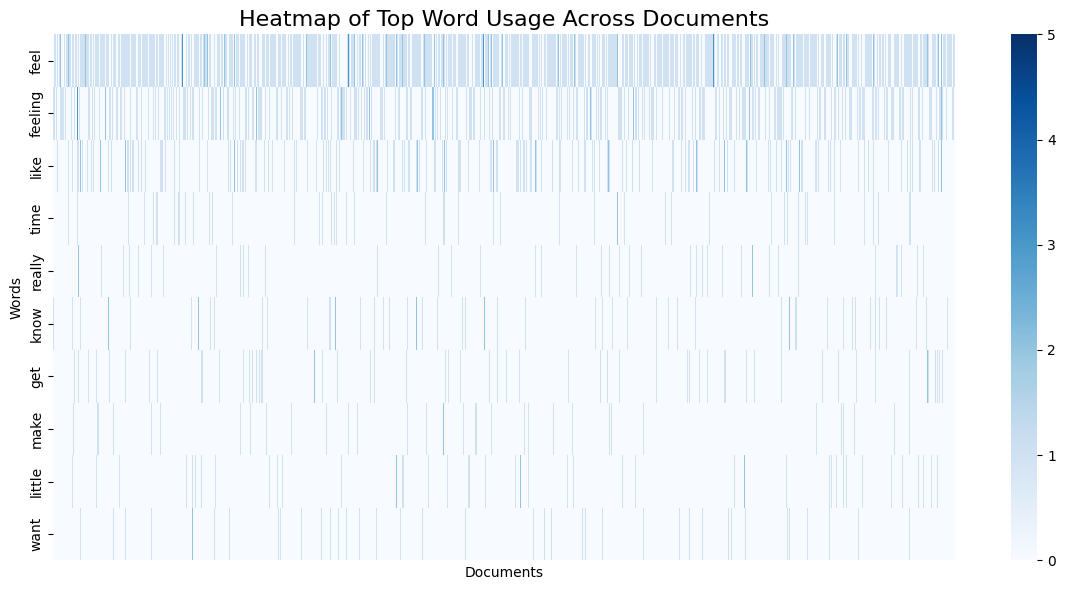

In [ ]:
import seaborn as sns

# Sum up all word counts across documents
word_counts = df_bow.sum(axis=0).sort_values(ascending=False)

# Pick top 10 frequent words
top_words = word_counts.head(10).index

# Create a mini-DataFrame with just those top words
mini_bow_df = df_bow[top_words]

# Plot a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(mini_bow_df.T, cmap='Blues', cbar=True)
plt.title('Heatmap of Top Word Usage Across Documents', fontsize=16)
plt.xlabel('Documents')
plt.ylabel('Words')
plt.xticks([], [])  # Optionally hide x-axis labels if too many documents
plt.tight_layout()
plt.show()


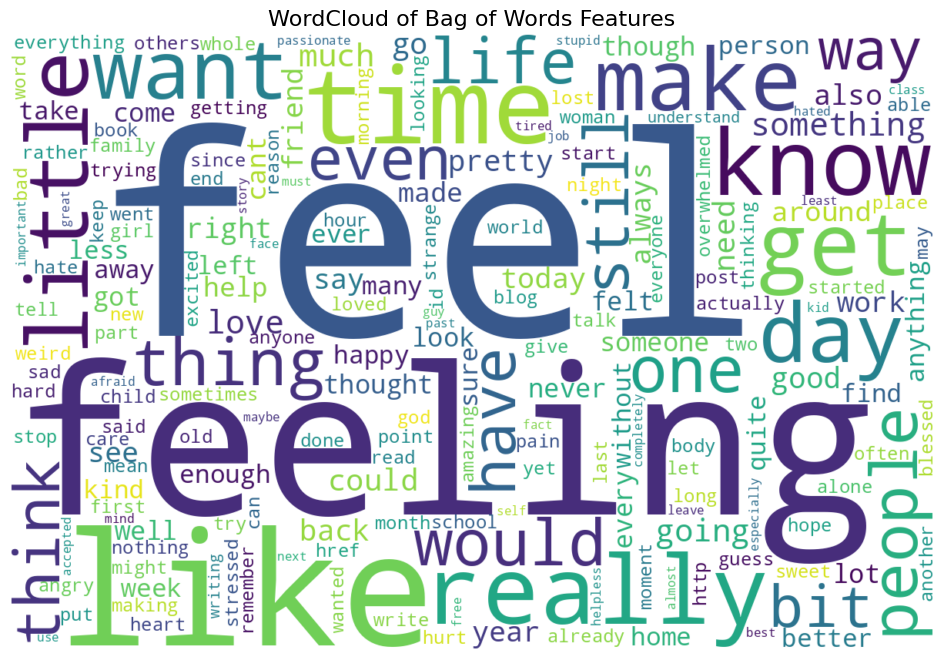

In [ ]:
from wordcloud import WordCloud

# Create a WordCloud
wordcloud = WordCloud(
    background_color='white',
    width=1200,
    height=800,
    max_words=200
).generate_from_frequencies(word_counts)

# Plot WordCloud
plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Bag of Words Features', fontsize=16)
plt.show()



In [ ]:
import plotly.express as px

# Create a DataFrame for Plotly
bow_plot_df = pd.DataFrame({
    'Word': word_counts.index,
    'Frequency': word_counts.values
})

# Build the interactive bar plot
fig = px.bar(
    bow_plot_df.head(30),  # Top 30 words
    x='Word',
    y='Frequency',
    title='Top 30 Most Frequent Words (Bag of Words) [Interactive]',
    labels={'Frequency': 'Word Count'},
    color='Frequency',
    color_continuous_scale='Blues'
)

fig.update_layout(
    xaxis_tickangle=-45,
    title_font_size=20,
    xaxis_title_font_size=16,
    yaxis_title_font_size=16,
    hoverlabel=dict(bgcolor="white", font_size=14, font_family="Arial"),
    plot_bgcolor='white'
)

fig.show()

# 🧠 **Part of Speech (POS) Tagging**

Part-of-speech tagging assigns a grammatical category (noun, verb, adjective, etc.) to each token in a sentence. This enriches our dataset with syntactic structure and can help detect linguistic patterns linked to emotional expression. For instance, frequent adjectives may indicate emotional intensity, while certain verb forms may align with mood or sentiment.


In [ ]:
from nltk import pos_tag
from nltk.util import ngrams
from itertools import chain
from collections import Counter
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
# Smart POS tagging function
def smart_pos_tag_tokens_to_df(tokens):
    # Check if it's a list of lists
    if any(isinstance(i, list) for i in tokens):
        # Flatten the tokens
        tokens = list(chain.from_iterable(tokens))

    # Now do POS tagging
    pos_tags = pos_tag(tokens)
    # Convert to DataFrame
    pos_df = pd.DataFrame(pos_tags, columns=['Word', 'POS'])
    return pos_df

In [ ]:
df_pos = smart_pos_tag_tokens_to_df(tokens)

df_pos

,Word,POS
0,feel,NN
1,humiliated,VBD
2,go,VBP
3,feeling,VBG
4,hopeless,NN
...,...,...
146021,know,VBP
146022,lot,NN
146023,feel,VB
146024,stupid,JJ


In [ ]:
# **Feature Engineering from POS Tags**
def generate_pos_features(df_pos):
    """
    Convert POS tags into categorical features that can be used for training.
    This example creates simple features based on the counts of POS categories.
    """
    pos_family = {
        'noun': ['NN', 'NNS', 'NNP', 'NNPS'],
        'verb': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
        'adjective': ['JJ', 'JJR', 'JJS'],
        'adverb': ['RB', 'RBR', 'RBS']
    }

    # Initialize feature counts
    features = {category: 0 for category in pos_family.keys()}

    # Count occurrences of each POS category in the sentence
    for tag in df_pos['POS']:
        for category, pos_tags in pos_family.items():
            if tag in pos_tags:
                features[category] += 1

    return features


In [ ]:
pos_features = generate_pos_features(df_pos)

pos_features

{'noun': 54793, 'verb': 37352, 'adjective': 30859, 'adverb': 13949}

In [ ]:
# Applying POS Tagging and Feature Extraction
pos_features = tokens.apply(lambda x: generate_pos_features(smart_pos_tag_tokens_to_df(x)))

In [ ]:
# Convert POS features into a DataFrame
df_pos_feature = pd.DataFrame(pos_features.tolist())

df_pos_feature

,noun,verb,adjective,adverb
0,1,1,0,0
1,5,2,1,0
2,4,1,1,0
3,2,2,1,2
4,1,1,0,0
...,...,...,...,...
15995,4,1,2,0
15996,3,3,2,1
15997,2,0,2,0
15998,3,0,1,0


In [ ]:
import plotly.express as px

pos_family = {
    'noun': ['NN', 'NNS', 'NNP', 'NNPS'],
    'verb': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
    'adjective': ['JJ', 'JJR', 'JJS'],
    'adverb': ['RB', 'RBR', 'RBS']
    }


# Function to map POS tags to a readable category
def map_pos_category(tag):
    for category, tags in pos_family.items():
        if tag in tags:
            return category
    return 'other'

# Function to plot bar chart and pie chart side-by-side
def side_by_side_pos_plots(pos_df):
    # Map POS tags to readable categories
    pos_df['POS Category'] = pos_df['POS'].apply(map_pos_category)

    # Count categories
    pos_counts = pos_df['POS Category'].value_counts()

    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- Bar Chart ---
    axes[0].bar(pos_counts.index, pos_counts.values)
    axes[0].set_xlabel('POS Category')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('POS Category Distribution (Bar Chart)')
    axes[0].grid(axis='y')

    # --- Pie Chart ---
    axes[1].pie(
        pos_counts.values,
        labels=pos_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        counterclock=False
    )
    axes[1].set_title('POS Category Distribution (Pie Chart)')
    axes[1].axis('equal')  # Equal aspect ratio for a perfect circle

    plt.tight_layout()
    plt.show()


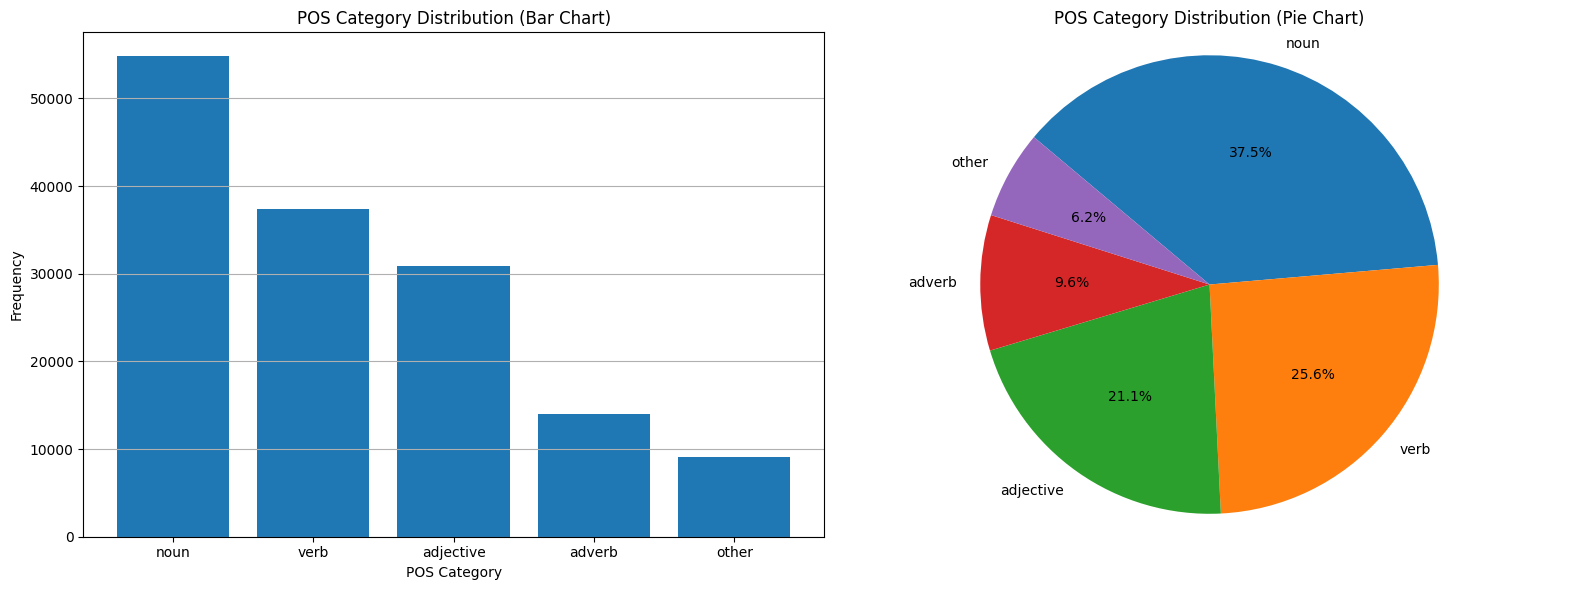

In [ ]:
# Assume you already have df_pos from POS tagging
side_by_side_pos_plots(df_pos)


# 🔗 **Dependency Parsing**

Dependency parsing analyzes the grammatical structure of a sentence by identifying relationships between words. This deeper syntactic analysis reveals how words influence one another, offering insights beyond flat token sequences. Such structural context can help capture complex emotional cues, especially when emotion depends on sentence phrasing or negation.


In [ ]:
import spacy

In [ ]:
# Load the English model
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Dependency parsing function
def dependency_parse(text):
    # Apply the model
    doc = nlp(text)

    # Create a DataFrame to store results
    parsed = pd.DataFrame(
        [(token.text, token.dep_, token.head.text) for token in doc],
        columns=['Word', 'Dependency', 'Head']
    )
    return parsed

In [ ]:
sentence = " ".join(df['text'])

In [ ]:
df_parsed = dependency_parse(sentence)

df_parsed

,Word,Dependency,Head
0,feel,nsubj,go
1,humiliated,acomp,feel
2,go,amod,love
3,feeling,xcomp,go
4,hopeless,acomp,feeling
...,...,...,...
147245,know,compound,lot
147246,lot,nsubj,feel
147247,feel,advcl,feel
147248,stupid,amod,portray


In [ ]:
from spacy import displacy

# Parse only one sentence (or a few sentences) properly
sample_text = df['text'].iloc[0]  # Take the first example (you can loop later)

doc = nlp(sample_text)

# Visualize with displaCy inside the notebook
displacy.render(doc, style="dep", jupyter=True)


In [ ]:
# Dependency Parsing Function to Extract Useful Features
def extract_dependency_features(text):
    """
    Extract features from dependency parsing, including dependency types and head words.
    This function returns a numerical representation of syntactic dependencies.
    """
    # Apply the dependency parser to the text
    doc = nlp(text)

    # Initialize feature dictionary
    dep_features = {
        'nsubj_count': 0, 'dobj_count': 0, 'ROOT_count': 0, 'amod_count': 0,
        'det_count': 0, 'prep_count': 0, 'pobj_count': 0, 'ccomp_count': 0, 'attr_count': 0,
        'avg_word_length': 0, 'avg_sentence_length': 0
    }

    # Count occurrences of each dependency
    for token in doc:
        if token.dep_ == 'nsubj': dep_features['nsubj_count'] += 1
        if token.dep_ == 'dobj': dep_features['dobj_count'] += 1
        if token.dep_ == 'ROOT': dep_features['ROOT_count'] += 1
        if token.dep_ == 'amod': dep_features['amod_count'] += 1
        if token.dep_ == 'det': dep_features['det_count'] += 1
        if token.dep_ == 'prep': dep_features['prep_count'] += 1
        if token.dep_ == 'pobj': dep_features['pobj_count'] += 1
        if token.dep_ == 'ccomp': dep_features['ccomp_count'] += 1
        if token.dep_ == 'attr': dep_features['attr_count'] += 1

    # Add average word and sentence length as additional features
    word_lengths = [len(token.text) for token in doc]
    dep_features['avg_word_length'] = np.mean(word_lengths) if word_lengths else 0
    dep_features['avg_sentence_length'] = len(doc)

    return dep_features

In [ ]:
# Apply dependency parsing to all sentences and create feature set
def generate_features_from_text(df):
    features_list = []
    for sentence in df['text']:
        dep_features = extract_dependency_features(sentence)
        features_list.append(dep_features)
    return pd.DataFrame(features_list)

In [ ]:
# Generate features using the dependency parsing function
df_features = generate_features_from_text(df)

In [ ]:
# Display the generated features
print(pd.DataFrame(df_features))

       nsubj_count  dobj_count  ROOT_count  amod_count  det_count  prep_count  \
0                0           0           1           0          0           0   
1                1           0           1           0          0           1   
2                0           1           1           1          0           0   
3                0           1           1           1          0           0   
4                0           1           1           0          0           0   
...            ...         ...         ...         ...        ...         ...   
15995            2           0           1           1          0           0   
15996            0           2           1           1          0           0   
15997            0           0           1           0          0           0   
15998            0           0           1           2          0           1   
15999            1           1           1           1          0           0   

       pobj_count  ccomp_co

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Combine Dependency Features with Other Features (e.g., TF-IDF, POS tags)
def combine_features_with_labels(df, dependency_features_df):
    """
    Combine dependency features with the label column into a complete feature set.
    """
    # Join the dependency features DataFrame with the original DataFrame
    combined_df = pd.concat([df, dependency_features_df], axis=1)

    # Encode labels (if necessary)
    label_encoder = LabelEncoder()
    combined_df['label_encoded'] = label_encoder.fit_transform(combined_df['label'])

    return combined_df, label_encoder

In [ ]:
# Combine features and labels
combined_df, label_encoder = combine_features_with_labels(df, df_features)

In [ ]:
combined_df

,text,label,nsubj_count,dobj_count,ROOT_count,amod_count,det_count,prep_count,pobj_count,ccomp_count,attr_count,avg_word_length,avg_sentence_length,label_encoded
0,feel humiliated,sadness,0,0,1,0,0,0,0,0,0,7.000000,2,4
1,go feeling hopeless damned hopeful around some...,sadness,1,0,1,0,0,1,0,0,0,5.777778,9,4
2,grabbing minute post feel greedy wrong,anger,0,1,1,1,0,0,0,0,0,5.500000,6,0
3,ever feeling nostalgic fireplace know still pr...,love,0,1,1,1,0,0,0,0,0,6.571429,7,3
4,feeling grouchy,anger,0,1,1,0,0,0,0,0,0,7.000000,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,brief time beanbag said anna feel like beaten,sadness,2,0,1,1,0,0,0,1,0,4.750000,8,4
15996,turning feel pathetic still waiting table subb...,sadness,0,2,1,1,0,0,0,0,0,6.333333,9,4
15997,feel strong good overall,joy,0,0,1,0,0,0,0,0,0,5.250000,4,2
15998,feel like rude comment glad,anger,0,0,1,2,0,1,1,0,0,4.600000,5,0


In [ ]:
import plotly.express as px

# Function to visualize the distribution of dependency types
def plot_dependency_distribution(dep_features_df):
    """
    Visualize the distribution of dependency types using Plotly.
    """
    # Sum up the counts of each dependency type across all sentences
    dep_feature_sums = dep_features_df.sum()

    # Convert to a DataFrame for easier plotting
    dep_feature_sums_df = pd.DataFrame(dep_feature_sums).reset_index()
    dep_feature_sums_df.columns = ['Dependency', 'Count']

    # Plot the distribution using Plotly
    fig = px.bar(
        dep_feature_sums_df,
        x='Dependency',
        y='Count',
        title='Distribution of Dependency Types Across Sentences',
        labels={'Dependency': 'Dependency Type', 'Count': 'Frequency'},
        color='Count',
        color_continuous_scale='Viridis'
    )
    fig.update_layout(xaxis_title="Dependency Type", yaxis_title="Count")
    fig.show()

# Visualize the distribution of dependency types
plot_dependency_distribution(df_features)


# 🧠 **Word2Vec Embeddings**

Unlike sparse vectorizers, **Word2Vec** creates dense word embeddings that capture semantic meaning based on context. Words that appear in similar contexts have similar vector representations. This allows models to understand emotional language more deeply, especially for cases where synonyms or subtle word choices carry different emotional weight.


In [ ]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 4.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
nlp = spacy.load("en_core_web_lg")

# Get the vector size from the model's meta data
vector_size = nlp.meta["vectors"]["width"]

# Function to get the mean vector for each document
def get_mean_vector(text):
    doc = nlp(text)

    # Get the word vectors for each token in the document, excluding stopwords and punctuation
    vectors = [token.vector for token in doc if not token.is_stop and not token.is_punct]

    # If there are valid vectors, compute the mean; otherwise, return a zero vector
    if len(vectors) > 0:
        mean_vector = np.mean(vectors, axis=0)
    else:
        mean_vector = np.zeros(vector_size)  # Return a zero vector if no valid tokens

    return mean_vector

# Apply the function to the clean_text column to get the mean vector for each document
word2vec_vector_features = df['text'].apply(get_mean_vector)

In [ ]:
df_word2vec = pd.DataFrame(np.array(word2vec_vector_features.tolist()))

df_word2vec

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.360075,0.250630,-0.074615,0.228087,0.108480,-0.115930,0.086310,0.014270,-0.531335,2.187700,...,0.279035,-0.017895,-0.007380,-0.150035,0.097312,0.329095,-0.259192,0.028991,0.274420,-0.011745
1,0.030344,0.090342,-0.136411,-0.004058,-0.206711,-0.236983,0.072513,0.017193,0.098721,2.269267,...,-0.041695,0.079111,0.104176,-0.088837,0.178889,0.284033,-0.089604,0.177880,-0.177412,-0.078955
2,-0.318812,0.035907,-0.138660,0.112157,-0.055872,0.158695,0.175864,-0.196551,-0.024551,2.039500,...,-0.086093,0.074726,-0.024348,-0.088004,0.264698,0.280118,-0.207320,0.021958,-0.070574,0.210405
3,0.347941,0.154223,-0.198376,-0.087834,0.004325,0.106886,0.301194,-0.294557,-0.121731,2.044142,...,-0.327562,0.029578,-0.038130,0.205895,0.167320,0.078427,-0.226398,0.014159,0.097510,0.341562
4,-0.021025,0.250493,-0.371750,-0.094749,-0.201684,0.572075,0.242985,-0.129716,0.076864,1.419750,...,0.136740,0.134082,0.532010,0.092680,0.363645,0.697095,0.088755,0.280230,-0.089397,-0.109280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,-0.009333,0.202583,-0.067554,0.077407,0.011941,-0.053474,-0.061358,-0.232190,-0.046099,1.855957,...,0.112225,0.050428,-0.032254,-0.135849,-0.015835,-0.041572,-0.207201,-0.054267,0.089484,0.141460
15996,-0.062059,0.013549,-0.076641,0.056439,0.060090,-0.034987,0.033513,-0.019924,-0.098261,2.027969,...,0.335698,-0.074771,0.013230,0.015367,0.094850,0.210396,-0.210645,0.130772,-0.214938,0.004103
15997,-0.292315,0.573550,-0.188175,0.097119,-0.019562,-0.020257,0.185692,-0.009600,0.046297,2.379475,...,-0.189367,0.132982,-0.138231,-0.117343,0.160912,0.152782,-0.073465,-0.194107,0.070282,0.069382
15998,-0.308326,0.332515,-0.452810,-0.018164,-0.122396,0.308696,0.332271,-0.451486,-0.141944,2.176660,...,0.045189,0.131032,-0.043061,-0.022107,0.291776,0.227740,-0.337780,0.011781,0.022656,0.258166


In [ ]:
from sklearn.decomposition import PCA

# Prepare your Word2Vec vectors
vectors = np.vstack(word2vec_vector_features.values)

# Reduce directly with PCA to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(vectors)

# Create a DataFrame
df_pca = pd.DataFrame()
df_pca['x'] = pca_result[:, 0]
df_pca['y'] = pca_result[:, 1]
df_pca['label'] = df['label']  # Assuming you have 'label' column
df_pca['text'] = df['text']         # Original text for hover

# Plot with Plotly
fig = px.scatter(
    df_pca,
    x='x',
    y='y',
    color='label',
    hover_data={'text': True, 'label': True},
    title='Word2Vec Mean Vectors Visualized with PCA (FAST & Interactive)',
    width=1000,
    height=700
)

fig.update_traces(marker=dict(size=7, opacity=0.7), selector=dict(mode='markers'))
fig.update_layout(legend_title_text='Emotions')

fig.show()

# 🎯 **Separating Features and Target**

Before training our model, we separate the independent features (text representations) from the dependent target (emotion labels). This distinction is crucial for supervised learning. Proper separation also allows us to modularize our training pipeline and reuse features across multiple model types.


In [ ]:
x_tf = df_tf_idf.drop(['label'], axis=1)
y_tf = df['label']

In [ ]:
x_bow = df_bow.drop(['label'], axis=1)
y_bow = df['label']

In [ ]:
x_pos = df_pos_feature
y_pos = df['label']

In [ ]:
x_dep = combined_df.drop(columns=['text', 'label', 'label_encoded'])
y_dep = combined_df['label']

In [ ]:
x_word2vec = df_word2vec
y_word2vec = df['label']

# 🔀 **Train-Test Split**

To evaluate generalization performance, we split our dataset into training and test sets. The training set is used to fit the model, while the test set simulates real-world, unseen data. We ensure this split is stratified — meaning the distribution of emotions remains balanced — to prevent bias and overfitting.


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train_tf, x_test_tf, y_train_tf, y_test_tf = train_test_split(x_tf, y_tf, random_state=42, test_size=0.2 )

In [ ]:
x_train_bow, x_test_bow, y_train_bow, y_test_bow = train_test_split(x_bow, y_bow, random_state=42, test_size=0.2 )

In [ ]:
x_train_pos, x_test_pos, y_train_pos, y_test_pos = train_test_split(x_pos, y_pos, random_state=42, test_size=0.2 )

In [ ]:
x_train_dep, x_test_dep, y_train_dep, y_test_dep = train_test_split(x_dep, y_dep, random_state=42, test_size=0.2 )

In [ ]:
x_train_word2vec, x_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(x_word2vec, y_word2vec, random_state=42, test_size=0.2 )

# 🔧 **Multilayer Perceptron (MLP)**

An MLP, or Multilayer Perceptron, is a type of feedforward neural network capable of learning complex, non-linear patterns in data. It consists of an input layer, one or more hidden layers, and an output layer. In our context, the MLP is used to classify text-based emotion features into one of several emotion categories. By experimenting with different input representations, we assess how well the MLP adapts to various types of linguistic and semantic data.

---

## **📊 Evaluation Metrics:**

- **Classification Report**: Displays precision, recall, F1-score, and support for both classes.
- **Confusion Matrix**: Helps identify how many predictions were true positives, false positives, etc.
- **Accuracy Score**: Used for final performance comparison across different models and feature types.


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## 🔧 **MLP for TF-IDF**

Here we feed TF-IDF vectors into an MLP. Although TF-IDF is a sparse, high-dimensional representation, the MLP is capable of identifying non-linear patterns in the weighted term features. This model can pick up on subtle combinations of keywords that strongly correlate with certain emotions — for instance, combinations of “disappointed”, “never”, and “expected” might strongly indicate *sadness*.


In [ ]:
mlp_tf = MLPClassifier()

In [ ]:
mlp_tf.fit(x_train_tf, y_train_tf)

MLPClassifier()

In [ ]:
y_pred_train_mlp_tf = mlp_tf.predict(x_train_tf)

In [ ]:
y_pred_test_mlp_tf = mlp_tf.predict(x_test_tf)

In [ ]:
print(classification_report(y_pred_train_mlp_tf, y_train_tf))

              precision    recall  f1-score   support

       anger       1.00      1.00      1.00      1733
        fear       1.00      1.00      1.00      1544
         joy       1.00      1.00      1.00      4332
        love       1.00      0.99      0.99      1017
     sadness       1.00      1.00      1.00      3719
    surprise       0.99      1.00      0.99       455

    accuracy                           1.00     12800
   macro avg       1.00      1.00      1.00     12800
weighted avg       1.00      1.00      1.00     12800



In [ ]:
print(classification_report(y_pred_test_mlp_tf, y_test_tf))

              precision    recall  f1-score   support

       anger       0.84      0.85      0.84       422
        fear       0.78      0.83      0.81       373
         joy       0.91      0.84      0.87      1107
        love       0.67      0.78      0.72       251
     sadness       0.90      0.88      0.89       964
    surprise       0.62      0.84      0.71        83

    accuracy                           0.85      3200
   macro avg       0.78      0.84      0.81      3200
weighted avg       0.85      0.85      0.85      3200



In [ ]:
print(confusion_matrix(y_pred_test_mlp_tf, y_test_tf))

[[357  20  12   2  31   0]
 [ 14 310   7   6  20  16]
 [ 20  30 930  77  37  13]
 [  1   1  43 197   7   2]
 [ 34  28  28  14 848  12]
 [  1   8   1   0   3  70]]


In [ ]:
accuracy_score_mlp_tf = accuracy_score(y_pred_test_mlp_tf, y_test_tf)
accuracy_score_mlp_tf

0.8475

In [ ]:
joblib.dump(mlp, 'MLP_Emotion_Prediction.joblib')

['MLP_Emotion_Prediction.joblib']

## 🔧 **MLP for CountVectorizer (BoW)**

This model uses raw word frequency vectors (from CountVectorizer) as input. While BoW does not capture context, the MLP compensates by learning hidden interactions between commonly co-occurring words. This setup is a good baseline for neural models using simple lexical features.


In [ ]:
mlp_bow = MLPClassifier()

In [ ]:
mlp_bow.fit(x_train_bow, y_train_bow)

MLPClassifier()

In [ ]:
y_pred_train_mlp_bow = mlp_bow.predict(x_train_bow)

In [ ]:
y_pred_test_mlp_bow = mlp_bow.predict(x_test_bow)

In [ ]:
print(classification_report(y_pred_train_mlp_bow, y_train_bow))

              precision    recall  f1-score   support

       anger       1.00      1.00      1.00      1731
        fear       0.99      1.00      1.00      1533
         joy       1.00      1.00      1.00      4354
        love       0.99      1.00      0.99       995
     sadness       1.00      1.00      1.00      3722
    surprise       1.00      0.98      0.99       465

    accuracy                           1.00     12800
   macro avg       1.00      1.00      1.00     12800
weighted avg       1.00      1.00      1.00     12800



In [ ]:
print(classification_report(y_pred_test_mlp_bow, y_test_bow))

              precision    recall  f1-score   support

       anger       0.85      0.86      0.86       419
        fear       0.78      0.85      0.81       368
         joy       0.92      0.85      0.88      1103
        love       0.68      0.80      0.74       252
     sadness       0.91      0.90      0.90       956
    surprise       0.70      0.77      0.73       102

    accuracy                           0.86      3200
   macro avg       0.81      0.84      0.82      3200
weighted avg       0.87      0.86      0.86      3200



In [ ]:
print(confusion_matrix(y_pred_test_mlp_bow, y_test_bow))

[[362  20  10   2  25   0]
 [ 12 311   5   7  18  15]
 [ 20  28 939  75  32   9]
 [  3   1  38 202   8   0]
 [ 27  24  26  10 859  10]
 [  3  13   3   0   4  79]]


In [ ]:
accuracy_score_mlp_bow = accuracy_score(y_pred_test_mlp_bow, y_test_bow)
accuracy_score_mlp_bow

0.86

## 🔧 **MLP for Part of Speech (POS) Tagging**

Here we use POS tagging features as the MLP’s input. These features capture the syntactic makeup of each sentence — the presence and sequence of verbs, adjectives, nouns, etc. The MLP can learn patterns like high adjective use being associated with *excitement* or *anger*, or first-person pronouns indicating *sadness* or *joy*.


In [ ]:
mlp_pos = MLPClassifier()

In [ ]:
mlp_pos.fit(x_train_pos, y_train_pos)

MLPClassifier()

In [ ]:
y_pred_train_mlp_pos = mlp_pos.predict(x_train_pos)

In [ ]:
y_pred_test_mlp_pos = mlp_pos.predict(x_test_pos)

In [ ]:
print(classification_report(y_pred_train_mlp_pos, y_train_pos, zero_division=0))

              precision    recall  f1-score   support

       anger       0.00      0.67      0.00         3
        fear       0.00      0.33      0.00         6
         joy       0.87      0.36      0.50     10586
        love       0.00      0.33      0.00         3
     sadness       0.21      0.36      0.27      2202
    surprise       0.00      0.00      0.00         0

    accuracy                           0.36     12800
   macro avg       0.18      0.34      0.13     12800
weighted avg       0.75      0.36      0.46     12800



In [ ]:
print(classification_report(y_pred_test_mlp_pos, y_test_pos, zero_division=0))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         0
        fear       0.00      1.00      0.01         1
         joy       0.86      0.33      0.48      2643
        love       0.00      0.00      0.00         2
     sadness       0.21      0.36      0.26       554
    surprise       0.00      0.00      0.00         0

    accuracy                           0.34      3200
   macro avg       0.18      0.28      0.12      3200
weighted avg       0.74      0.34      0.44      3200



In [ ]:
print(confusion_matrix(y_pred_test_mlp_pos, y_test_pos))

[[  0   0   0   0   0   0]
 [  0   1   0   0   0   0]
 [341 329 874 254 747  98]
 [  1   0   0   0   1   0]
 [ 85  67 147  42 198  15]
 [  0   0   0   0   0   0]]


In [ ]:
accuracy_score_mlp_pos = accuracy_score(y_pred_test_mlp_pos, y_test_pos)
accuracy_score_mlp_pos

0.3353125

## 🔧 **MLP for Dependency Parsing**

With dependency parsing features, the MLP attempts to model emotional signals from grammatical relationships, such as subject-verb-object structures or negation cues. This setup tests whether deeper linguistic context improves classification performance when paired with non-linear modeling.


In [ ]:
mlp_dep = MLPClassifier()

In [ ]:
mlp_dep.fit(x_train_dep, y_train_dep)

MLPClassifier()

In [ ]:
y_pred_train_mlp_dep = mlp_dep.predict(x_train_dep)

In [ ]:
y_pred_test_mlp_dep = mlp_dep.predict(x_test_dep)

In [ ]:
print(classification_report(y_pred_train_mlp_dep, y_train_dep, zero_division=0))

              precision    recall  f1-score   support

       anger       0.01      0.59      0.02        27
        fear       0.00      0.00      0.00         0
         joy       0.82      0.36      0.50      9987
        love       0.00      1.00      0.00         1
     sadness       0.27      0.36      0.31      2785
    surprise       0.00      0.00      0.00         0

    accuracy                           0.36     12800
   macro avg       0.18      0.38      0.14     12800
weighted avg       0.70      0.36      0.45     12800



In [ ]:
print(classification_report(y_pred_test_mlp_dep, y_test_dep, zero_division=0))

              precision    recall  f1-score   support

       anger       0.00      0.20      0.00         5
        fear       0.00      0.00      0.00         0
         joy       0.78      0.32      0.46      2469
        love       0.00      0.00      0.00         0
     sadness       0.26      0.34      0.30       726
    surprise       0.00      0.00      0.00         0

    accuracy                           0.33      3200
   macro avg       0.17      0.14      0.13      3200
weighted avg       0.66      0.33      0.42      3200



In [ ]:
print(confusion_matrix(y_pred_test_mlp_dep, y_test_dep))

[[  1   2   0   1   1   0]
 [  0   0   0   0   0   0]
 [320 305 801 251 698  94]
 [  0   0   0   0   0   0]
 [106  90 220  44 247  19]
 [  0   0   0   0   0   0]]


In [ ]:
accuracy_score_mlp_dep = accuracy_score(y_pred_test_mlp_dep, y_test_dep)
accuracy_score_mlp_dep

0.3278125

## 🔧 **MLP for Word2Vec**

Finally, we train the MLP on Word2Vec embeddings, which provide dense semantic representations of the text. This combination allows the neural network to capture emotional nuance based on word similarity and contextual meaning. It’s particularly useful when different words express the same emotion in subtle ways (e.g., “furious” vs. “irate”).


In [ ]:
mlp_word2vec = MLPClassifier()

In [ ]:
mlp_word2vec.fit(x_train_word2vec, y_train_word2vec)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [ ]:
y_pred_train_mlp_word2vec = mlp_word2vec.predict(x_train_word2vec)

In [ ]:
y_pred_test_mlp_word2vec = mlp_word2vec.predict(x_test_word2vec)

In [ ]:
print(classification_report(y_pred_train_mlp_word2vec, y_train_word2vec))

              precision    recall  f1-score   support

       anger       1.00      1.00      1.00      1731
        fear       1.00      0.99      1.00      1548
         joy       1.00      1.00      1.00      4348
        love       0.99      0.99      0.99      1004
     sadness       1.00      1.00      1.00      3715
    surprise       0.98      1.00      0.99       454

    accuracy                           1.00     12800
   macro avg       0.99      1.00      0.99     12800
weighted avg       1.00      1.00      1.00     12800



In [ ]:
print(classification_report(y_pred_test_mlp_word2vec, y_test_word2vec))

              precision    recall  f1-score   support

       anger       0.71      0.71      0.71       427
        fear       0.66      0.68      0.67       388
         joy       0.81      0.75      0.78      1103
        love       0.52      0.65      0.58       239
     sadness       0.80      0.80      0.80       950
    surprise       0.47      0.57      0.51        93

    accuracy                           0.74      3200
   macro avg       0.66      0.69      0.67      3200
weighted avg       0.74      0.74      0.74      3200



In [ ]:
print(confusion_matrix(y_pred_test_mlp_word2vec, y_test_word2vec))

[[303  30  26  13  51   4]
 [ 28 262  31   9  38  20]
 [ 30  40 829  94  85  25]
 [  2   9  61 155  11   1]
 [ 60  44  58  22 756  10]
 [  4  12  16   3   5  53]]


In [ ]:
accuracy_score_mlp_word2vec = accuracy_score(y_pred_test_mlp_word2vec, y_test_word2vec)
accuracy_score_mlp_word2vec

0.736875

# 🌲 **Decision Tree Models**

Decision Trees are interpretable, rule-based classifiers that split data based on feature values. In emotion classification, they allow us to trace which features lead to specific emotion predictions. While they may not always outperform neural models, their transparency is a key advantage for analysis and debugging.


In [ ]:
from sklearn.tree import DecisionTreeClassifier

## 🌲 **Decision Tree for TF-IDF**

Using TF-IDF vectors, we train a Decision Tree classifier. Each decision node is based on word importance scores, allowing the tree to isolate terms that strongly indicate certain emotions. This setup offers a balance between interpretability and effectiveness for sparse features.


In [ ]:
dt_tf = DecisionTreeClassifier()

In [ ]:
dt_tf.fit(x_train_tf, y_train_tf)

DecisionTreeClassifier()

In [ ]:
y_pred_train_dt_tf = dt_tf.predict(x_train_tf)

In [ ]:
y_pred_test_dt_tf = dt_tf.predict(x_test_tf)

In [ ]:
print(classification_report(y_pred_train_dt_tf, y_train_tf))

              precision    recall  f1-score   support

       anger       1.00      1.00      1.00      1739
        fear       1.00      1.00      1.00      1545
         joy       1.00      1.00      1.00      4356
        love       0.99      1.00      0.99       993
     sadness       1.00      1.00      1.00      3714
    surprise       0.99      1.00      0.99       453

    accuracy                           1.00     12800
   macro avg       0.99      1.00      1.00     12800
weighted avg       1.00      1.00      1.00     12800



In [ ]:
print(classification_report(y_pred_test_dt_tf, y_test_tf))

              precision    recall  f1-score   support

       anger       0.86      0.86      0.86       426
        fear       0.87      0.81      0.84       427
         joy       0.89      0.89      0.89      1020
        love       0.76      0.80      0.78       284
     sadness       0.90      0.90      0.90       943
    surprise       0.67      0.76      0.71       100

    accuracy                           0.87      3200
   macro avg       0.83      0.84      0.83      3200
weighted avg       0.87      0.87      0.87      3200



In [ ]:
print(confusion_matrix(y_pred_test_dt_tf, y_test_tf))

[[366  14  11   5  30   0]
 [ 20 346  14   4  25  18]
 [ 16   9 909  55  22   9]
 [  2   0  44 226  11   1]
 [ 21  16  39   6 852   9]
 [  2  12   4   0   6  76]]


In [ ]:
accuracy_score_dt_tf = accuracy_score(y_pred_test_dt_tf, y_test_tf)
accuracy_score_dt_tf

0.8671875

## 🌲 **Decision Tree for CountVectorizer (BoW)**

Here we apply a Decision Tree on Bag-of-Words features. The model examines raw word frequencies and creates a flow of binary decisions to classify emotions. This method, while simple, can still perform well with well-distributed datasets.


In [ ]:
dt_bow = MLPClassifier()

In [ ]:
dt_bow.fit(x_train_bow, y_train_bow)

MLPClassifier()

In [ ]:
y_pred_train_dt_bow = dt_bow.predict(x_train_bow)

In [ ]:
y_pred_test_dt_bow = dt_bow.predict(x_test_bow)

In [ ]:
print(classification_report(y_pred_train_dt_bow, y_train_bow))

              precision    recall  f1-score   support

       anger       1.00      1.00      1.00      1737
        fear       1.00      1.00      1.00      1545
         joy       1.00      1.00      1.00      4342
        love       0.99      0.99      0.99      1007
     sadness       1.00      1.00      1.00      3716
    surprise       0.99      1.00      0.99       453

    accuracy                           1.00     12800
   macro avg       1.00      1.00      1.00     12800
weighted avg       1.00      1.00      1.00     12800



In [ ]:
print(classification_report(y_pred_test_dt_bow, y_test_bow))

              precision    recall  f1-score   support

       anger       0.85      0.86      0.86       423
        fear       0.81      0.84      0.83       384
         joy       0.90      0.87      0.88      1067
        love       0.71      0.76      0.74       276
     sadness       0.91      0.90      0.90       951
    surprise       0.70      0.80      0.75        99

    accuracy                           0.86      3200
   macro avg       0.82      0.84      0.83      3200
weighted avg       0.86      0.86      0.86      3200



In [ ]:
print(confusion_matrix(y_pred_test_dt_bow, y_test_bow))

[[365  18  11   2  27   0]
 [ 10 323   7   7  21  16]
 [ 18  22 923  67  28   9]
 [  3   1  51 211   9   1]
 [ 29  22  26   9 857   8]
 [  2  11   3   0   4  79]]


In [ ]:
accuracy_score_dt_bow = accuracy_score(y_pred_test_dt_bow, y_test_bow)
accuracy_score_dt_bow

0.861875

## 🌲 **Decision Tree for Part of Speech (POS) Tagging**

With part-of-speech tagging, the Decision Tree uses syntactic patterns as a basis for classification. This can uncover grammar-based cues in emotional language — for instance, excessive use of adjectives or interjections might be linked to excitement or anger.


In [ ]:
dt_pos = MLPClassifier()

In [ ]:
dt_pos.fit(x_train_pos, y_train_pos)

MLPClassifier()

In [ ]:
y_pred_train_dt_pos = dt_pos.predict(x_train_pos)

In [ ]:
y_pred_test_dt_pos = dt_pos.predict(x_test_pos)

In [ ]:
print(classification_report(y_pred_train_dt_pos, y_train_pos, zero_division=0))

              precision    recall  f1-score   support

       anger       0.00      0.50      0.00         6
        fear       0.00      0.00      0.00         0
         joy       0.92      0.35      0.51     11397
        love       0.00      0.00      0.00         0
     sadness       0.14      0.37      0.20      1397
    surprise       0.00      0.00      0.00         0

    accuracy                           0.35     12800
   macro avg       0.18      0.20      0.12     12800
weighted avg       0.84      0.35      0.48     12800



In [ ]:
print(classification_report(y_pred_test_dt_pos, y_test_pos, zero_division=0))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         1
        fear       0.00      1.00      0.01         1
         joy       0.92      0.33      0.49      2855
        love       0.00      0.00      0.00         0
     sadness       0.14      0.40      0.21       343
    surprise       0.00      0.00      0.00         0

    accuracy                           0.34      3200
   macro avg       0.18      0.29      0.12      3200
weighted avg       0.84      0.34      0.46      3200



In [ ]:
print(confusion_matrix(y_pred_test_dt_pos, y_test_pos))

[[  0   0   0   1   0   0]
 [  0   1   0   0   0   0]
 [369 360 942 269 810 105]
 [  0   0   0   0   0   0]
 [ 58  36  79  26 136   8]
 [  0   0   0   0   0   0]]


In [ ]:
accuracy_score_dt_pos = accuracy_score(y_pred_test_dt_pos, y_test_pos)
accuracy_score_dt_pos

0.3371875

## 🌲 **Decision Tree for Dependency Parsing**

We evaluate how a Decision Tree performs on syntactic structures from dependency parsing. This helps test the utility of rule-based methods on hierarchical linguistic features and complements our neural network experiments.


In [ ]:
dt_dep = DecisionTreeClassifier()

In [ ]:
dt_dep.fit(x_train_dep, y_train_dep)

DecisionTreeClassifier()

In [ ]:
y_pred_train_dt_dep = dt_dep.predict(x_train_dep)

In [ ]:
y_pred_test_dt_dep = dt_dep.predict(x_test_dep)

In [ ]:
print(classification_report(y_pred_train_dt_dep, y_train_dep, zero_division=0))

              precision    recall  f1-score   support

       anger       0.78      0.72      0.75      1865
        fear       0.71      0.77      0.74      1428
         joy       0.84      0.78      0.81      4668
        love       0.70      0.89      0.78       792
     sadness       0.77      0.76      0.77      3790
    surprise       0.54      0.96      0.69       257

    accuracy                           0.77     12800
   macro avg       0.72      0.81      0.76     12800
weighted avg       0.78      0.77      0.78     12800



In [ ]:
print(classification_report(y_pred_test_dt_dep, y_test_dep, zero_division=0))

              precision    recall  f1-score   support

       anger       0.14      0.13      0.14       447
        fear       0.11      0.12      0.11       353
         joy       0.37      0.33      0.35      1161
        love       0.09      0.13      0.10       204
     sadness       0.29      0.29      0.29       969
    surprise       0.03      0.05      0.03        66

    accuracy                           0.25      3200
   macro avg       0.17      0.17      0.17      3200
weighted avg       0.26      0.25      0.25      3200



In [ ]:
print(confusion_matrix(y_pred_test_dt_dep, y_test_dep))

[[ 60  51 136  46 136  18]
 [ 55  43 104  24 109  18]
 [153 142 381 109 339  37]
 [ 29  30  45  26  67   7]
 [119 126 335  82 277  30]
 [ 11   5  20   9  18   3]]


In [ ]:
accuracy_score_dt_dep = accuracy_score(y_pred_test_dt_dep, y_test_dep)
accuracy_score_dt_dep

0.246875

## 🌲 **Decision Tree for Word2Vec**

A Decision Tree using Word2Vec features is less common due to the continuous nature of the embeddings. However, it's a useful experiment to see how much structure the tree can extract from rich semantic vectors, especially compared to linear models.


In [ ]:
dt_word2vec = DecisionTreeClassifier()

In [ ]:
dt_word2vec.fit(x_train_word2vec, y_train_word2vec)

DecisionTreeClassifier()

In [ ]:
y_pred_train_dt_word2vec = dt_word2vec.predict(x_train_word2vec)

In [ ]:
y_pred_test_dt_word2vec = dt_word2vec.predict(x_test_word2vec)

In [ ]:
print(classification_report(y_pred_train_dt_word2vec, y_train_word2vec))

              precision    recall  f1-score   support

       anger       1.00      0.99      1.00      1743
        fear       1.00      0.99      1.00      1547
         joy       1.00      1.00      1.00      4358
        love       0.98      1.00      0.99       990
     sadness       1.00      1.00      1.00      3711
    surprise       0.98      1.00      0.99       451

    accuracy                           1.00     12800
   macro avg       0.99      1.00      1.00     12800
weighted avg       1.00      1.00      1.00     12800



In [ ]:
print(classification_report(y_pred_test_dt_word2vec, y_test_word2vec))

              precision    recall  f1-score   support

       anger       0.34      0.32      0.33       451
        fear       0.32      0.30      0.31       433
         joy       0.55      0.53      0.54      1067
        love       0.18      0.23      0.20       230
     sadness       0.48      0.51      0.49       882
    surprise       0.08      0.07      0.07       137

    accuracy                           0.42      3200
   macro avg       0.33      0.33      0.32      3200
weighted avg       0.42      0.42      0.42      3200



In [ ]:
print(confusion_matrix(y_pred_test_dt_word2vec, y_test_word2vec))

[[146  61  85  19 126  14]
 [ 56 129  90  30 113  15]
 [ 75  82 561 135 177  37]
 [ 21  12  94  53  44   6]
 [113  94 145  47 451  32]
 [ 16  19  46  12  35   9]]


In [ ]:
accuracy_score_dt_word2vec = accuracy_score(y_pred_test_dt_word2vec, y_test_word2vec)
accuracy_score_dt_word2vec

0.4215625

# 🧪 **Logistic Regression Models**

Logistic Regression is a classic, efficient algorithm for classification tasks. Despite its simplicity, it can perform competitively when paired with informative features. We apply it across different representations to establish strong, interpretable baselines.


In [ ]:
from sklearn.linear_model import LogisticRegression

## 🧪 **Logistic Regression for TF-IDF**

TF-IDF vectors work particularly well with Logistic Regression. The model treats each weighted term as a feature and learns coefficients indicating its emotional impact. This pairing is often used in production systems for its speed and clarity.


In [ ]:
log_tf = LogisticRegression()

In [ ]:
log_tf.fit(x_train_tf, y_train_tf)

LogisticRegression()

In [ ]:
y_pred_train_log_tf = log_tf.predict(x_train_tf)

In [ ]:
y_pred_test_log_tf = log_tf.predict(x_test_tf)

In [ ]:
print(classification_report(y_pred_train_log_tf, y_train_tf))

              precision    recall  f1-score   support

       anger       0.93      0.97      0.95      1657
        fear       0.93      0.95      0.94      1496
         joy       0.98      0.92      0.95      4632
        love       0.80      0.97      0.88       837
     sadness       0.98      0.95      0.97      3832
    surprise       0.73      0.96      0.83       346

    accuracy                           0.95     12800
   macro avg       0.89      0.95      0.92     12800
weighted avg       0.95      0.95      0.95     12800



In [ ]:
print(classification_report(y_pred_test_log_tf, y_test_tf))

              precision    recall  f1-score   support

       anger       0.81      0.90      0.85       383
        fear       0.74      0.86      0.80       343
         joy       0.96      0.79      0.87      1243
        love       0.56      0.90      0.69       184
     sadness       0.94      0.90      0.92       990
    surprise       0.44      0.88      0.59        57

    accuracy                           0.85      3200
   macro avg       0.74      0.87      0.79      3200
weighted avg       0.88      0.85      0.86      3200



In [ ]:
print(confusion_matrix(y_pred_test_log_tf, y_test_tf))

[[345  17   3   4  14   0]
 [ 11 295   3   3   9  22]
 [ 42  53 982 109  33  24]
 [  0   0  16 166   1   1]
 [ 29  25  17  14 889  16]
 [  0   7   0   0   0  50]]


In [ ]:
accuracy_score_log_tf = accuracy_score(y_pred_test_log_tf, y_test_tf)
accuracy_score_log_tf

0.8521875

## 🧪 **Logistic Regression for CountVectorizer (BoW)**

This setup evaluates Logistic Regression on raw frequency counts. While BoW lacks nuance, it's often sufficient for emotion detection in shorter texts where repetition is meaningful. This model provides a simple but solid benchmark.


In [ ]:
log_bow = LogisticRegression()

In [ ]:
log_bow.fit(x_train_bow, y_train_bow)

LogisticRegression()

In [ ]:
y_pred_train_log_bow = log_bow.predict(x_train_bow)

In [ ]:
y_pred_test_log_bow = log_bow.predict(x_test_bow)

In [ ]:
print(classification_report(y_pred_train_log_bow, y_train_bow))

              precision    recall  f1-score   support

       anger       0.98      0.99      0.98      1716
        fear       0.98      0.98      0.98      1548
         joy       0.99      0.99      0.99      4351
        love       0.97      0.98      0.98       996
     sadness       0.99      0.99      0.99      3737
    surprise       0.96      0.97      0.97       452

    accuracy                           0.99     12800
   macro avg       0.98      0.98      0.98     12800
weighted avg       0.99      0.99      0.99     12800



In [ ]:
print(classification_report(y_pred_test_log_bow, y_test_bow))

              precision    recall  f1-score   support

       anger       0.87      0.90      0.89       415
        fear       0.85      0.85      0.85       394
         joy       0.94      0.89      0.91      1077
        love       0.78      0.84      0.81       276
     sadness       0.93      0.93      0.93       945
    surprise       0.70      0.85      0.77        93

    accuracy                           0.89      3200
   macro avg       0.85      0.88      0.86      3200
weighted avg       0.90      0.89      0.89      3200



In [ ]:
print(confusion_matrix(y_pred_test_log_bow, y_test_bow))

[[373  14   6   2  20   0]
 [ 16 336   4   3  14  21]
 [ 17  19 959  55  21   6]
 [  1   3  33 231   8   0]
 [ 18  17  17   4 882   7]
 [  2   8   2   1   1  79]]


In [ ]:
accuracy_score_log_bow = accuracy_score(y_pred_test_log_bow, y_test_bow)
accuracy_score_log_bow

0.89375

## 🧪 **Logistic Regression for Part of Speech (POS) Tagging**

Here, we input POS tag frequencies or encodings into a Logistic Regression model. This setup tests whether syntactic patterns alone can predict emotional content — a useful indicator of the power of language structure.


In [ ]:
log_pos = LogisticRegression()

In [ ]:
log_pos.fit(x_train_pos, y_train_pos)

LogisticRegression()

In [ ]:
y_pred_train_log_pos = log_pos.predict(x_train_pos)

In [ ]:
y_pred_test_log_pos = log_pos.predict(x_test_pos)

In [ ]:
print(classification_report(y_pred_train_log_pos, y_train_pos, zero_division=0))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         0
        fear       0.00      0.00      0.00         0
         joy       0.88      0.35      0.50     10995
        love       0.00      0.00      0.00         0
     sadness       0.16      0.33      0.21      1805
    surprise       0.00      0.00      0.00         0

    accuracy                           0.35     12800
   macro avg       0.17      0.11      0.12     12800
weighted avg       0.78      0.35      0.46     12800



In [ ]:
print(classification_report(y_pred_test_log_pos, y_test_pos, zero_division=0))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         0
        fear       0.00      0.00      0.00         0
         joy       0.90      0.33      0.48      2774
        love       0.00      0.00      0.00         0
     sadness       0.17      0.38      0.23       426
    surprise       0.00      0.00      0.00         0

    accuracy                           0.34      3200
   macro avg       0.18      0.12      0.12      3200
weighted avg       0.80      0.34      0.45      3200



In [ ]:
print(confusion_matrix(y_pred_test_log_pos, y_test_pos))

[[  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [374 345 917 257 785  96]
 [  0   0   0   0   0   0]
 [ 53  52 104  39 161  17]
 [  0   0   0   0   0   0]]


In [ ]:
accuracy_score_log_pos = accuracy_score(y_pred_test_log_pos, y_test_pos)
accuracy_score_log_pos

0.336875

## 🧪 **Logistic Regression for Dependency Parsing**

We now test how Logistic Regression handles dependency parsing features. While not designed for hierarchical data, this experiment helps us measure how far linear models can go with structured syntactic input.


In [ ]:
log_dep = LogisticRegression()

In [ ]:
log_dep.fit(x_train_dep, y_train_dep)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred_train_log_dep = log_dep.predict(x_train_dep)

In [ ]:
y_pred_test_log_dep = log_dep.predict(x_test_dep)

In [ ]:
print(classification_report(y_pred_train_log_dep, y_train_dep, zero_division=0))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         0
        fear       0.00      0.00      0.00         2
         joy       0.86      0.35      0.50     10777
        love       0.00      0.00      0.00         0
     sadness       0.19      0.35      0.24      2021
    surprise       0.00      0.00      0.00         0

    accuracy                           0.35     12800
   macro avg       0.18      0.12      0.12     12800
weighted avg       0.76      0.35      0.46     12800



In [ ]:
print(classification_report(y_pred_test_log_dep, y_test_dep, zero_division=0))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         0
        fear       0.00      0.00      0.00         1
         joy       0.84      0.32      0.47      2662
        love       0.00      0.00      0.00         0
     sadness       0.20      0.35      0.25       537
    surprise       0.00      0.00      0.00         0

    accuracy                           0.33      3200
   macro avg       0.17      0.11      0.12      3200
weighted avg       0.73      0.33      0.43      3200



In [ ]:
print(confusion_matrix(y_pred_test_log_dep, y_test_dep))

[[  0   0   0   0   0   0]
 [  0   0   0   0   1   0]
 [351 332 860 266 756  97]
 [  0   0   0   0   0   0]
 [ 76  65 161  30 189  16]
 [  0   0   0   0   0   0]]


In [ ]:
accuracy_score_log_dep = accuracy_score(y_pred_test_log_dep, y_test_dep)
accuracy_score_log_dep

0.3278125

## 🧪 **Logistic Regression for Word2Vec**

Finally, we combine the linear simplicity of Logistic Regression with the semantic depth of Word2Vec embeddings. Though it lacks non-linear layers to interpret vector geometry fully, this pairing can still yield solid performance in many use cases.


In [ ]:
log_word2vec = LogisticRegression()

In [ ]:
log_word2vec.fit(x_train_word2vec, y_train_word2vec)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred_train_log_word2vec = log_word2vec.predict(x_train_word2vec)

In [ ]:
y_pred_test_log_word2vec = log_word2vec.predict(x_test_word2vec)

In [ ]:
print(classification_report(y_pred_train_log_word2vec, y_train_word2vec))

              precision    recall  f1-score   support

       anger       0.68      0.77      0.72      1531
        fear       0.67      0.76      0.71      1340
         joy       0.86      0.77      0.82      4844
        love       0.52      0.71      0.60       743
     sadness       0.82      0.76      0.79      4023
    surprise       0.49      0.71      0.58       319

    accuracy                           0.76     12800
   macro avg       0.67      0.75      0.70     12800
weighted avg       0.78      0.76      0.77     12800



In [ ]:
print(classification_report(y_pred_test_log_word2vec, y_test_word2vec))

              precision    recall  f1-score   support

       anger       0.65      0.72      0.68       385
        fear       0.65      0.71      0.68       363
         joy       0.88      0.73      0.80      1223
        love       0.45      0.72      0.55       183
     sadness       0.78      0.75      0.77       983
    surprise       0.35      0.62      0.44        63

    accuracy                           0.73      3200
   macro avg       0.62      0.71      0.65      3200
weighted avg       0.76      0.73      0.74      3200



In [ ]:
print(confusion_matrix(y_pred_test_log_word2vec, y_test_word2vec))

[[276  25  13  12  56   3]
 [ 18 259  19   9  42  16]
 [ 32  45 894 117 100  35]
 [  6   2  36 132   7   0]
 [ 90  55  54  25 739  20]
 [  5  11   5   1   2  39]]


In [ ]:
accuracy_score_log_word2vec = accuracy_score(y_pred_test_log_word2vec, y_test_word2vec)
accuracy_score_log_word2vec

0.7309375

# 📊 **Creating a Table for Visualizing and Comparing Methods**

To summarize our results, we compile all model performances into a comparison table. This helps us:
- Identify the most effective feature-model combinations  
- Observe trends across representation types  
- Make informed decisions about trade-offs between accuracy and interpretability


In [ ]:
import plotly.graph_objects as go

# Calculate evaluation metrics for each model
models = ['MLP_tf', 'MLP_bow', 'MLP_pos', 'MLP_dep', 'MLP_word2vec',
          'Decision Tree_tf', 'Decision Tree_bow', 'Decision Tree_pos', 'Decision Tree_dep', 'Decision Tree_word2vec',
          'Logistic Regression_tf', 'Logistic Regression_bow', 'Logistic Regression_pos', 'Logistic Regression_dep', 'Logistic Regression_word2vec'

]

accuracy_scores = [
    accuracy_score_mlp_tf, accuracy_score_mlp_bow, accuracy_score_mlp_pos, accuracy_score_mlp_dep, accuracy_score_mlp_word2vec,
    accuracy_score_dt_tf, accuracy_score_dt_bow, accuracy_score_dt_pos, accuracy_score_dt_dep, accuracy_score_dt_word2vec,
    accuracy_score_log_tf, accuracy_score_log_bow, accuracy_score_log_pos, accuracy_score_log_dep, accuracy_score_log_word2vec
]

# Plotting the comparison using Plotly
fig = go.Figure()

# Add traces for each evaluation metric
fig.add_trace(go.Bar(
    x=models,
    y=accuracy_scores,
    name='Accuracy',
    marker_color='blue'
))

# Customize the layout of the figure
fig.update_layout(
    title="Model Performance Comparison",
    barmode='group',  # Group the bars together for each model
    xaxis_title="Models",
    yaxis_title="Scores",
    template="plotly_dark",  # Dark theme for the plot
    legend_title="Metrics",
    font=dict(family="Arial, sans-serif", size=14),
    height=500,  # Adjust the height of the chart
    width=800,  # Adjust the width of the chart
)

# Show the plot
fig.show()

In [ ]:
# Create a pandas DataFrame for the evaluation metrics
performance_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy_scores
})

# Sort the table by Accuracy (or any other metric, e.g., 'F1 Score')
performance_df_sorted = performance_df.sort_values(by='Accuracy', ascending=False)

# Display the sorted table
print(performance_df_sorted.to_string(index=False))

                       Model  Accuracy
     Logistic Regression_bow  0.893750
            Decision Tree_tf  0.867188
           Decision Tree_bow  0.861875
                     MLP_bow  0.860000
      Logistic Regression_tf  0.852187
                      MLP_tf  0.847500
                MLP_word2vec  0.736875
Logistic Regression_word2vec  0.730938
      Decision Tree_word2vec  0.421563
           Decision Tree_pos  0.337187
     Logistic Regression_pos  0.336875
                     MLP_pos  0.335313
                     MLP_dep  0.327813
     Logistic Regression_dep  0.327813
           Decision Tree_dep  0.246875


## 📝 Model Evaluation & Insights

### 🎯 Purpose of the Evaluation

The goal of this evaluation is to compare the performance of multiple machine learning models across various feature extraction techniques in the task of **emotion detection from text**. We aim to:

1. **Benchmark Model Accuracy**  
   Quantitatively assess how well each model performs using standard accuracy metrics.

2. **Compare Feature Engineering Methods**  
   Understand which text representation techniques (TF-IDF, Bag of Words, Word2Vec, POS, Dependency Parsing) lead to more informative inputs.

3. **Identify Optimal Combinations**  
   Determine the most effective pairings of models and feature types for future deployment or research.

---

### 📊 Accuracy Summary

| Model                             | Accuracy  |
|----------------------------------|-----------|
| Logistic Regression (BoW)        | **0.8938** |
| Decision Tree (TF-IDF)           | 0.8672    |
| Decision Tree (BoW)              | 0.8619    |
| MLP (BoW)                         | 0.8600    |
| Logistic Regression (TF-IDF)     | 0.8522    |
| MLP (TF-IDF)                      | 0.8475    |
| MLP (Word2Vec)                    | 0.7369    |
| Logistic Regression (Word2Vec)   | 0.7309    |
| Decision Tree (Word2Vec)         | 0.4216    |
| Decision Tree (POS)              | 0.3372    |
| Logistic Regression (POS)        | 0.3369    |
| MLP (POS)                         | 0.3353    |
| MLP (Dependency Parsing)         | 0.3278    |
| Logistic Regression (Dependency) | 0.3278    |
| Decision Tree (Dependency)       | **0.2469** |

---

### 🔍 Key Insights

#### ✅ **Best Performing Model: Logistic Regression with Bag-of-Words**
- Achieved the highest accuracy at **89.4%**, outperforming all neural and tree-based methods.
- Its effectiveness with BoW suggests that simple frequency-based word presence captures strong emotional cues.
- Logistic Regression also performed strongly with TF-IDF, reinforcing its value for sparse vector inputs.

#### 🌲 **Strong Tree-Based Performance with TF-IDF and BoW**
- **Decision Trees** scored over **86% accuracy** with both TF-IDF and BoW inputs.
- Their rule-based nature benefits from clearly defined term patterns, especially in high-dimensional feature spaces.
- A promising choice when interpretability and decision flow transparency are important.

#### 🧠 **MLP Shows Solid Performance with Sparse Inputs**
- **MLP with BoW** (86%) and **TF-IDF** (84.8%) performed competitively, confirming the network's ability to learn non-linear representations from basic frequency data.
- While slightly behind Logistic Regression, MLP offers room for future performance gains through deeper architectures or fine-tuning.

#### 📉 **Word2Vec Performance is Lower than Expected**
- MLP and Logistic Regression with Word2Vec embeddings scored in the **73% range** — lower than expected.
- Indicates that dense embeddings alone may not offer sufficient emotional separability in this context, possibly due to short text inputs or lack of contextual depth.

#### ⚠️ **Syntactic Features (POS and Dependency Parsing) Underperform**
- Models trained on **POS tags** and **dependency features** consistently scored below **34%**.
- Suggests these features, while linguistically rich, do not carry strong standalone predictive power for emotion classification in this dataset.
- Might be more effective when used in conjunction with semantic or contextual embeddings.

#### ❌ **Worst Performer: Decision Tree with Dependency Parsing**
- The lowest accuracy recorded was **24.7%**, using a Decision Tree with dependency parsing features.
- Highlights the limitation of using structured grammatical relations without semantic or frequency-based support.

---

### 🧠 Conclusion

- **Logistic Regression with Bag-of-Words** is the most accurate and reliable model-feature pairing in this study. It balances simplicity, speed, and predictive power.
- **Decision Trees** deliver competitive results and provide strong interpretability, particularly with TF-IDF features.
- **MLP models** are promising, especially with sparse vectors, and could benefit from deeper architectures or regularization.
- **Word2Vec alone may not be sufficient** for emotion detection in short-form texts — hybrid approaches or contextualized embeddings (e.g., BERT) may offer improvements.
- **POS and Dependency Parsing** should be considered as auxiliary features, not primary ones.

---




### 💼 Practical Applications of This Emotion Detection System

The emotion classification models developed in this project can be directly or adaptively applied in various real-world contexts. Here are several domains and use cases where this work holds strong relevance:

---

#### 🧘 **Mental Health Monitoring**
- Detecting emotional cues in written text can assist therapists, counselors, or digital platforms in identifying users expressing signs of emotional distress.
- Can be integrated into chat-based mental health apps for flagging high-risk expressions like persistent sadness or anger.

---

#### 📱 **Social Media Analysis**
- This system can be applied to platforms like Twitter, Reddit, or YouTube comments to:
  - Track public sentiment during major events
  - Identify emotional trends around products, policies, or personalities
  - Flag harmful or toxic content early

---

#### 🤖 **Customer Service & Chatbots**
- Emotion-aware bots can adapt their tone and responses based on user sentiment.
- Customer support systems can prioritize emotionally urgent queries or escalate cases where anger or frustration is detected.

---

#### 📊 **Market Research and Brand Monitoring**
- Analyzing product reviews or customer feedback for emotional tone helps:
  - Gauge customer satisfaction beyond numerical ratings
  - Identify subtle issues or highlights that drive user sentiment

---

#### 🎓 **Educational Technology**
- In e-learning platforms, tracking student emotions from forum posts or chat messages can help personalize support and improve engagement.

---

#### ⚙️ **Text Analytics and Feedback Systems**
- Organizations can process large volumes of textual feedback to:
  - Monitor employee or customer morale
  - Detect early signs of dissatisfaction or disengagement
  - Enrich qualitative analysis with emotional dimensions
  
---

> This project not only serves as a strong academic exercise in NLP and classification, but also offers a deployable, adaptable solution for real-world emotion-aware applications across tech, healthcare, education, and marketing industries.


# ⚡ **Prediction Pipeline**

We design an end-to-end prediction pipeline that chains preprocessing, feature extraction, and classification into one seamless unit. This modular approach simplifies deployment and enables consistent behavior across different environments.


In [ ]:
import re
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import joblib

In [ ]:
# Open and read the file
with open('train.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

# Separate into features and labels
features = []
labels = []

for line in lines:
    if ';' in line:
        text, emotion = line.strip().split(';')
        features.append(text)
        labels.append(emotion)

# Create a DataFrame
df = pd.DataFrame({
    'text': features,
    'label': labels
})

In [ ]:
# Download required NLTK data
nltk.download('wordnet')
nltk.download('stopwords')


# Independent preprocessing function
def preprocess_text(text):
    # Contractions dictionary
    contractions_dict = {
        r'\b(ve)\b': "have",
        r'\b(ive)\b': "I've",
        r'\b(im)\b': "I'm",
        r'\b(ill)\b': "I'll",
        r'\b(it)\b': "it",
        r'\b(can t)\b': "can't",
        r'\b(wont)\b': "won't",
        r'\b(dont)\b': "don't",
        r'\b(isn t)\b': "isn't",
        r'\b(arent)\b': "aren't",
        r'\b(have)\b': "have",
        r'\b(willnot)\b': "won't",
        r'\b(wouldve)\b': "would've",
        r'\b(shouldve)\b': "should've",
        r'\b(mightve)\b': "might've",
        r'\b(mustve)\b': "must've",
        r'\b(didnt)\b': "didn't"
    }

    # Fix contractions
    for pattern, replacement in contractions_dict.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

    # Lemmatize and remove stopwords
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [
        lemmatizer.lemmatize(word.lower())
        for word in words
        if word.lower() not in stop_words
    ]

    return " ".join(filtered_words)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['text'] = df['text'].apply(preprocess_text)

In [ ]:
df

,text,label
0,feel humiliated,sadness
1,go feeling hopeless damned hopeful around some...,sadness
2,grabbing minute post feel greedy wrong,anger
3,ever feeling nostalgic fireplace know still pr...,love
4,feeling grouchy,anger
...,...,...
15995,brief time beanbag said anna feel like beaten,sadness
15996,turning feel pathetic still waiting table subb...,sadness
15997,feel strong good overall,joy
15998,feel like rude comment glad,anger


In [ ]:
# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),  # BoW vectorization
    ('classifier', LogisticRegression())  # Logistic Regression
])

# Fit the pipeline
pipeline.fit(df['text'], df['label'])

# Save the pipeline
joblib.dump(pipeline, "/content/drive/MyDrive/AmirHossein_Drive/LogisticandBoWPipeline2.joblib")

['/content/drive/MyDrive/AmirHossein_Drive/LogisticandBoWPipeline2.joblib']

In [ ]:
import numpy
print(numpy.__version__)

2.0.2


# **Using Pipeline**

In [ ]:
import joblib
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
estimator = joblib.load('/content/drive/MyDrive/AmirHossein_Drive/LogisticandBoWPipeline.joblib')

In [ ]:
# Download required NLTK data
nltk.download('wordnet')
nltk.download('stopwords')


# Independent preprocessing function
def preprocess_text(text):
    # Contractions dictionary
    contractions_dict = {
        r'\b(ve)\b': "have",
        r'\b(ive)\b': "I've",
        r'\b(im)\b': "I'm",
        r'\b(ill)\b': "I'll",
        r'\b(it)\b': "it",
        r'\b(can t)\b': "can't",
        r'\b(wont)\b': "won't",
        r'\b(dont)\b': "don't",
        r'\b(isn t)\b': "isn't",
        r'\b(arent)\b': "aren't",
        r'\b(have)\b': "have",
        r'\b(willnot)\b': "won't",
        r'\b(wouldve)\b': "would've",
        r'\b(shouldve)\b': "should've",
        r'\b(mightve)\b': "might've",
        r'\b(mustve)\b': "must've",
        r'\b(didnt)\b': "didn't"
    }

    # Fix contractions
    for pattern, replacement in contractions_dict.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

    # Lemmatize and remove stopwords
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [
        lemmatizer.lemmatize(word.lower())
        for word in words
        if word.lower() not in stop_words
    ]

    return " ".join(filtered_words)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
text = str(input('give me a text'))
text_pre = preprocess_text(text)
text_pre = [text_pre]
print(estimator.predict(text_pre))

give me a texti was scared
['fear']


In [ ]:
! pip install streamlit

In [ ]:
import streamlit as st

# Streamlit app UI
st.set_page_config(page_title="Emotion Predictor", layout="centered")
st.title("🧠 Emotion Detection from Text")
st.markdown("Type a sentence below and get the **predicted emotion**!")

user_input = st.text_area("Your text here:", "")

if st.button("Analyze Emotion"):
    if user_input.strip():
        preprocessed = preprocess_text(user_input)
        prediction = pipeline.predict([preprocessed])[0]
        st.success(f"### 🗣️ Detected Emotion: **{prediction.capitalize()}**")
    else:
        st.warning("⚠️ Please enter some text before clicking analyze.")

2025-05-13 11:21:38.909 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-13 11:21:38.911 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-13 11:21:38.912 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-13 11:21:38.913 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-13 11:21:38.914 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-13 11:21:38.915 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-13 11:21:38.916 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-13 11:21:38.917 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
streamlit run emotion_app.py

SyntaxError: invalid syntax (<ipython-input-13-d671593ee6c1>, line 1)